### Setup libraries

In [1]:
# !pip install deeppavlov

### Import libraries

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:72.5% !important; }</style>"))

In [2]:
import tensorflow as tf

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import os
import io
import re
import time
import unicodedata
from tqdm.notebook import tqdm

from tensorflow.keras import layers
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import tensorflow_datasets as tfds

In [3]:
plt.rcParams.update({'font.size': 14})
pd.set_option('precision', 3)
pd.set_option('max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('max_colwidth', 300)

In [4]:
# %tensorflow_version 2.x
# import tensorflow as tf
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#     raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

### Paths to directories and files

In [5]:
DRAFT_DATASET_PATH = 'E:/kaggle/mailru/Otvety.txt'

### Loading data

In [6]:
lines = io.open(DRAFT_DATASET_PATH, encoding='UTF-8').read()#.strip().split('\n')

### Preprocessing data

In [7]:
def preprocess_text(w):
    w = re.sub(':\)', '', w)
    w = re.sub('[)"]', '', w)
    w = re.sub('<[^>]+>', ' ', w)
    
    w = re.sub('\s*\?\s*\.', '?', w)
    w = re.sub('\s*\!\s*\.', '!', w)
    w = re.sub('\s*\.', '.', w)
    w = re.sub('\.+', '.', w)
    
    #     w = w.lower().strip()
    w = re.sub('---', 'QUESTION', w)
    
    return w

In [8]:
# print(type(lines))
print(len(lines))

1072593541


In [9]:
NUM_EXAMPLES = 7777777
text = preprocess_text(str(lines[:NUM_EXAMPLES]))
print(text[:1000])


QUESTION
вопрос о ТДВ давно и хорошо отдыхаем ЛИЧНО ВАМ здесь кого советовали завести? 
хомячка. 
мужика, йопаря, собачку и 50 кошек. 
Общение! 
паучка. 
Да пол мне бы памыть! А таг то ни чо. Типа ни каво! 
я тут вообще что бы пообщаться. 
А мне советовали сиси завести. 
Ну, слава богу, мужика завести ещё не советовали А вот сватать к кому только не сватали. 
мне тут советовали завести любовника, мужа и много кошек  приветик. 
QUESTION
Как парни относятся к цветным линзам? Если у девушки то зеленые глаза, то голубые. 
меня вобще прикалывает эта тема. 
когда этобыло редкость - было забавно, а когда все знают, что эта фальшивка, то уже не прикольно, как силиконовые сиськи или как налепленные синтетические волосы. 
QUESTION
Что делать, сегодня нашёл 2 миллиона рублей? 
Если это счастье  действительно на вас свалилось, лучше пойти в милицию и заявить о находке. Такие деньги просто так не терют, а что самое интересное их неприменно будут искать и поверьте мне найдут, видел подобное в жизни

In [10]:
def split_by_sentence(sent):
    sent = text.split('\nQUESTION\n')[1:]
    
    question = []
    answer = []

    for se in sent:
        se = se.split('\n')
        question.append(se[0].strip())
#         question.append(se[0])
#         answer.append(' '.join([f'<start_answers> {s}<stop_answers>' for s in se[1:]]))
#         answer.append(' '.join([f'<start> {s}<stop>' for s in se[1:]]))
        answer.append(' '.join([f' {s}' for s in se[1:]]))
    
    return question, answer

In [11]:
question, answer = split_by_sentence(text)
question[0], answer[0]

('вопрос о ТДВ давно и хорошо отдыхаем ЛИЧНО ВАМ здесь кого советовали завести?',
 ' хомячка.   мужика, йопаря, собачку и 50 кошек.   Общение!   паучка.   Да пол мне бы памыть! А таг то ни чо. Типа ни каво!   я тут вообще что бы пообщаться.   А мне советовали сиси завести.   Ну, слава богу, мужика завести ещё не советовали А вот сватать к кому только не сватали.   мне тут советовали завести любовника, мужа и много кошек  приветик. ')

In [12]:
# df = pd.DataFrame({'questions':question, 'answers':answer})

In [13]:
# df.head()

In [14]:
# for w in df['questions']:
#     re.sub('[^a-zA-Zа-яА-Я,.!?]+', ' ', w)

# for w in df['answers']:
#     re.sub('[^a-zA-Zа-яА-Я,.!?]+', ' ', w)

### Tokenizer

In [15]:
def split_by_subwords(corpus_generator, file_name=None):
    start = time.time()
    tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
        corpus_generator = corpus_generator, 
        target_vocab_size = 2**13)
    if file_name:
        tokenizer.save_to_file(file_name)
        
    print(f'in {round(time.time() - start)} sec.')
    return tokenizer

In [16]:
try:
    tokenizer_en = tfds.deprecated.text.SubwordTextEncoder.load_from_file('tokenizer_en')
    print('tokenizer_en loaded')
except UnicodeDecodeError:
    tokenizer_en = split_by_subwords(
        corpus_generator = (sent for sent in question + answer),
        file_name='tokenizer_en')

tokenizer_en loaded


### Prep datasets

In [17]:
MAX_LEN = 40

token_inp = [tokenizer_en.encode(q) for q in question]
token_tar = [tokenizer_en.encode(a) for a in answer]

token_inp = tf.keras.preprocessing.sequence.pad_sequences(token_inp, maxlen=MAX_LEN, padding='post', dtype='int64')
token_tar = tf.keras.preprocessing.sequence.pad_sequences(token_tar, maxlen=MAX_LEN, padding='post', dtype='int64')

print(token_inp.shape, token_tar.shape)
token_inp, token_tar

(8603, 40) (8603, 40)


(array([[ 630,   29,  304, ...,    0,    0,    0],
        [ 113, 5238, 8433, ...,    0,    0,    0],
        [ 180,  507,    1, ...,    0,    0,    0],
        ...,
        [6911, 8433, 3499, ...,    0,    0,    0],
        [8103,   17,    1, ...,    0,    0,    0],
        [  91,   10,  229, ...,    0,    0,    0]], dtype=int64),
 array([[   1, 6563, 2918, ..., 3234,  669,    2],
        [ 145, 5635,  718, ...,    9, 2063,    2],
        [   1,   28, 1322, ..., 1481, 1290,    2],
        ...,
        [8433, 5998,    2, ...,    0,    0,    0],
        [   6, 1113, 1243, ..., 6739,  996,    2],
        [1133,   51, 1113, ...,    5, 1344,  114]], dtype=int64))

In [18]:
def encode(answer, question):
    answer = [tokenizer_en.vocab_size] + list(answer.numpy()) + [tokenizer_en.vocab_size + 1]
    question = [tokenizer_en.vocab_size] + list(question.numpy()) + [tokenizer_en.vocab_size + 1]
    return answer, question

def tf_encode(answer, question):
    answer, question = tf.py_function(func=encode, inp=[answer, question], Tout=[tf.int64, tf.int64])
    answer.set_shape([None])
    question.set_shape([None])
    return answer, question

In [19]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

start = time.time()

dataset = tf.data.Dataset.from_tensor_slices((token_inp, token_tar))
dataset = dataset.map(tf_encode)
dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.padded_batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

print(next(iter(dataset)))
print(f'in {round(time.time() - start)} sec.')

(<tf.Tensor: shape=(64, 42), dtype=int64, numpy=
array([[8657,   35,  123, ...,    0,    0, 8658],
       [8657,  482,  501, ...,    0,    0, 8658],
       [8657, 2481, 3800, ...,    0,    0, 8658],
       ...,
       [8657,  551,  173, ...,  342, 8447, 8658],
       [8657,   35,  123, ...,    0,    0, 8658],
       [8657, 8057,  280, ...,    0,    0, 8658]], dtype=int64)>, <tf.Tensor: shape=(64, 42), dtype=int64, numpy=
array([[8657,   10,  282, ..., 1800,  449, 8658],
       [8657,    1,    6, ...,   99,    2, 8658],
       [8657, 1652, 7425, ..., 2682,    2, 8658],
       ...,
       [8657,    7,  389, ...,  353,    2, 8658],
       [8657,  662, 8446, ...,  118,    2, 8658],
       [8657,  576, 8433, ..., 2181,    2, 8658]], dtype=int64)>)
in 2 sec.


In [20]:
for inp, tar in dataset.take(1):
    print('input: ' + tokenizer_en.decode(inp[0][1:-2]))
    print('target: ' + tokenizer_en.decode(tar[0][1:-2]))

input:  (при просроченном долге более 10 тыс. руб., которых будут сажать в тюрьму, ТО что станет со СТРАНОЙ? Куда мы катимся
target: мщика! что в доли с ними были? а как насчет того что безработным кредитные карты присылали? ну ладно, подождем увидем


### Positional encoding

In [21]:
def get_angles(pos, i, d_model):
    angle_rates = pos * (1 / np.power(10_000, (2 * (i // 2)) / np.float32(d_model)))
    return angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(
        np.arange(position)[:, np.newaxis],
        np.arange(d_model)[np.newaxis, :],
        d_model
    )
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]
    pos_encoding = tf.cast(pos_encoding, dtype=tf.float32)
    return pos_encoding

(1, 50, 512)


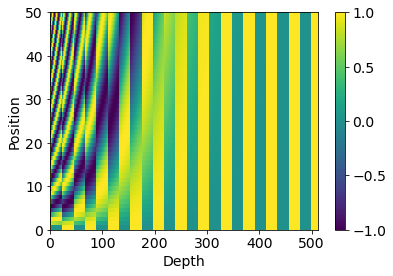

In [22]:
pos_encoding = positional_encoding(50, 512)
print(pos_encoding.shape)

plt.pcolormesh(pos_encoding[0])
plt.xlabel('Depth')
plt.ylabel('Position')
plt.colorbar()
plt.show()

### Masking

In [23]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    seq = seq[:, tf.newaxis, tf.newaxis, :]
    return seq

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

def create_masks(inp, tar):
    enc_padding_mask = create_padding_mask(inp)
    dec_padding_mask = create_padding_mask(inp)
    
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
    return enc_padding_mask, combined_mask, dec_padding_mask

### Scaled dot product attention

In [24]:
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    dk = tf.math.sqrt(dk)
    
    scaled_attention_logits = matmul_qk / dk

    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    output = tf.matmul(attention_weights, v)
    return output, attention_weights

### Multi-head attention

In [25]:
class MultiHeadAttention(layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        
        self.num_heads = num_heads
        self.d_model = d_model
        
        assert d_model % self.num_heads == 0
        
        self.depth = d_model // self.num_heads
        
        self.wq = layers.Dense(d_model)
        self.wk = layers.Dense(d_model)
        self.wv = layers.Dense(d_model)
        
        self.dense = layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        x = tf.transpose(x, perm=[0, 2, 1, 3])
        return x
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)
        
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        
        output, weight = scaled_dot_product_attention(q, k, v, mask)
        
        output = tf.transpose(output, perm=[0, 2, 1, 3])
        output = tf.reshape(output, (batch_size, -1, self.d_model))
        output = self.dense(output)
        return output, weight

### Point wise feed forward network

In [26]:
def point_wise_feed_forward_network(d_model, dff):
    seq = tf.keras.Sequential([
        layers.Dense(dff, activation='relu'),
        layers.Dense(d_model)
    ])
    return seq

### Encoder layer

In [27]:
class EncoderLayer(layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()
        
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
        
    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)
        
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)
        return out2

### Decoder layer

In [28]:
class DecoderLayer(layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()
        
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)
        
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
        self.dropout3 = layers.Dropout(rate)
        
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)
        
        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)
        
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)
        return out3, attn_weights_block1, attn_weights_block2

### Encoder

In [29]:
class Encoder(layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()
        
        self.d_model = d_model
        self.num_layers = num_layers
        
        self.embedding = layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)
        
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = layers.Dropout(rate)
        
    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]
        
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)
        
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
        return x

### Decoder

In [30]:
class Decoder(layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()
        
        self.d_model = d_model
        self.num_layers = num_layers
        
        self.embedding = layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
        
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = layers.Dropout(rate)
        
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}
        
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)
        
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)
            attention_weights[f'decoder_layer{i+1}_block1'] = block1
            attention_weights[f'decoder_layer{i+1}_block2'] = block2
            
        return x, attention_weights

In [31]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()
        
        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_input, rate)
        
        self.final_layer = layers.Dense(target_vocab_size)
        
    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)
        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)
        final_output = self.final_layer(dec_output)
        return final_output, attention_weights

### Hyperparameters

In [32]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = tokenizer_en.vocab_size + 2
target_vocab_size = tokenizer_en.vocab_size + 2
dropout_rate = 0.1

### Optimizer

In [33]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4_000):
        super(CustomSchedule, self).__init__()
        
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
        
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [34]:
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

### Loss and metrics

In [35]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

In [36]:
def loss_function(real, pred):
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
    loss = loss_object(real, pred)
    
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    mask = tf.cast(mask, dtype=loss.dtype)
    
    loss *= mask
    loss = tf.reduce_sum(loss) / tf.reduce_sum(mask)
    return loss

def accuracy_function(real, pred):
    acc = tf.equal(real, tf.argmax(pred, axis=2))
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    
    acc = tf.math.logical_and(mask, acc)
    acc = tf.cast(acc, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    
    acc = tf.reduce_sum(acc) / tf.reduce_sum(mask)
    return acc

### Model init

In [37]:
transformer = Transformer(
    num_layers, d_model, num_heads, dff,
    input_vocab_size, target_vocab_size, 
    pe_input=input_vocab_size,
    pe_target=target_vocab_size,
    rate=dropout_rate
)

### Checkpointing

In [38]:
checkpoint_path = './checkpoints/train'

ckpt = tf.train.Checkpoint(
    transformer=transformer,
    optimizer=optimizer
)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=1)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

### Training

In [39]:
# train_step_signature = [
#     tf.TensorSpec(shape=(None, None), dtype=tf.int64),
#     tf.TensorSpec(shape=(None, None), dtype=tf.int64)
# ]

# @tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
    
    enc_padding_mask, combine_mask, dec_padding_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        pred, _ = transformer(
            inp, tar_inp, True,
            enc_padding_mask,
            combine_mask,
            dec_padding_mask
        )
        loss = loss_function(tar_real, pred)
        
    grad = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(grad, transformer.trainable_variables))
    
    train_loss(loss)
    train_accuracy(accuracy_function(tar_real, pred))

In [49]:
EPOCHS = 5
training = True

if training:
    for epoch in range(EPOCHS):
        start = time.time()

        train_loss.reset_states()
        train_accuracy.reset_states()

        for batch, (inp, tar) in enumerate(dataset):
            train_step(inp, tar)
        
        print (f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
        print (f'Time taken for 1 epoch: {round(time.time() - start)} secs')
        ckpt_manager.save()
        print (f'Saving checkpoint for epoch {epoch + 1}\n')

Epoch 1 Loss 6.3536 Accuracy 0.1223
Time taken for 1 epoch: 153 secs
Saving checkpoint for epoch 1

Epoch 2 Loss 6.1867 Accuracy 0.1296
Time taken for 1 epoch: 152 secs
Saving checkpoint for epoch 2

Epoch 3 Loss 6.0471 Accuracy 0.1358
Time taken for 1 epoch: 153 secs
Saving checkpoint for epoch 3

Epoch 4 Loss 5.9099 Accuracy 0.1430
Time taken for 1 epoch: 160 secs
Saving checkpoint for epoch 4

Epoch 5 Loss 5.7677 Accuracy 0.1513
Time taken for 1 epoch: 163 secs
Saving checkpoint for epoch 5



### Evaluate

In [45]:
def evaluate(inp_sentence):
    start_token = [tokenizer_en.vocab_size]
    end_token = [tokenizer_en.vocab_size + 1]
    
    inp_sentence = start_token + tokenizer_en.encode(inp_sentence) + end_token
    encoder_input = tf.expand_dims(inp_sentence, 0)

    decoder_input = [tokenizer_en.vocab_size]
    output = tf.expand_dims(decoder_input, 0)

    for i in range(MAX_LEN):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, output)

        predictions, attention_weights = transformer(
            encoder_input, output, False,
            enc_padding_mask, combined_mask, dec_padding_mask
        )
        predictions = predictions[:, -1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        if predicted_id == tokenizer_en.vocab_size+1:
            return tf.squeeze(output, axis=0), attention_weights

        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0), attention_weights

In [46]:
def text_generator(sentence):
    result, attention_weights = evaluate(sentence)
    predicted_sentence = tokenizer_en.decode([i for i in result if i < tokenizer_en.vocab_size - 1])
    
    print(f'Input: {sentence}')
    print(f'Predicted message: {predicted_sentence}')
    return predicted_sentence

In [47]:
text_generator('Что такое ЭБУ?')

Input: Что такое ЭБУ?
Predicted message:  А не не не не не не не не не не не не не не не не не не не не не не не не не не не не не не не не не не не не не . 


' А не не не не не не не не не не не не не не не не не не не не не не не не не не не не не не не не не не не не не . '

In [48]:
text_generator('Как дела?')

Input: Как дела?
Predicted message:  А не не не не не не не не не не не не не не не не не не не не не не не не не не не не не не не не не не не не не . 


' А не не не не не не не не не не не не не не не не не не не не не не не не не не не не не не не не не не не не не . '

In [15]:
def tokenize(text):
    text_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    text_tokenizer.fit_on_texts(text)

    tensor = text_tokenizer.texts_to_sequences(text)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post') # add , dtype='int64'

    return tensor, text_tokenizer

In [16]:
def load_dataset(question, answer):
    # creating cleaned input, output pairs
    inp_text, targ_text = question, answer

    input_tensor, inp_text_tokenizer = tokenize(inp_text)
    target_tensor, targ_text_tokenizer = tokenize(targ_text)

    return input_tensor, target_tensor, inp_text_tokenizer, targ_text_tokenizer

In [17]:
len(question), len(answer)

(627, 627)

In [18]:
# Try experimenting with the size of that dataset
input_tensor, target_tensor, inp_text, targ_text = load_dataset(question, answer)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [19]:
def convert(text, tensor):
    for t in tensor:
        if t!=0:
            print ("%d ----> %s" % (t, text.index_word[t]))

In [20]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

501 501 126 126


In [22]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 32
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_text.word_index) + 1
vocab_tar_size = len(targ_text.word_index) + 1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [23]:
vocab_tar_size

23661

In [24]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([32, 395]), TensorShape([32, 1245]))

In [25]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=False,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [26]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_hidden = encoder(example_input_batch, sample_hidden)
# print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder Hidden state shape: (batch size, units) (32, 1024)


In [27]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

    def call(self, x, hidden):
        # enc_output shape == (batch_size, max_length, hidden_size)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x, initial_state=hidden)

        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state

In [28]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

decoder_sample_x, decoder_sample_h = decoder(tf.random.uniform((BATCH_SIZE, 1)), sample_hidden)

In [29]:
decoder_sample_x.shape

TensorShape([32, 23661])

In [30]:
decoder_sample_h.shape

TensorShape([32, 1024])

In [31]:
optimizer = tf.keras.optimizers.Adam()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [32]:
checkpoint_dir = './training_nmt_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [33]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([targ_text.word_index['<start>']] * BATCH_SIZE, 1)

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden = decoder(dec_input, dec_hidden)

            loss += loss_function(targ[:, t], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [ ]:
EPOCHS = 5

for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, batch_loss.numpy()))
            
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1, total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

In [ ]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [ ]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [ ]:
def text_generator(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
text_generator('Что такое ЭБУ?.')

### BERT Question Answering

In [15]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers

from tokenizers import BertWordPieceTokenizer

In [16]:
class Sample:
    def __init__(self, question, context, start_char_idx=None, answer_text=None, all_answers=None):
        self.question = question
        self.context = context
        self.start_char_idx = start_char_idx
        self.answer_text = answer_text
        self.all_answers = all_answers
        self.skip = False
        self.start_token_idx = -1
        self.end_token_idx = -1

    def preprocess(self):
        # clean context and question
        context = " ".join(str(self.context).split())
        question = " ".join(str(self.question).split())
        # tokenize context and question
        tokenized_context = tokenizer.encode(context)
        tokenized_question = tokenizer.encode(question)
        # if this is validation or training sample, preprocess answer
        if self.answer_text is not None:
            answer = " ".join(str(self.answer_text).split())
            # check if end character index is in the context
            end_char_idx = self.start_char_idx + len(answer)
            if end_char_idx >= len(context):
                self.skip = True
                return
            # mark all the character indexes in context that are also in answer     
            is_char_in_ans = [0] * len(context)
            for idx in range(self.start_char_idx, end_char_idx):
                is_char_in_ans[idx] = 1
            ans_token_idx = []
            # find all the tokens that are in the answers
            for idx, (start, end) in enumerate(tokenized_context.offsets):
                if sum(is_char_in_ans[start:end]) > 0:
                    ans_token_idx.append(idx)
            if len(ans_token_idx) == 0:
                self.skip = True
                return
            # get start and end token indexes
            self.start_token_idx = ans_token_idx[0]
            self.end_token_idx = ans_token_idx[-1]
        # create inputs as usual
        input_ids = tokenized_context.ids + tokenized_question.ids[1:]
        token_type_ids = [0] * len(tokenized_context.ids) + [1] * len(tokenized_question.ids[1:])
        attention_mask = [1] * len(input_ids)
        padding_length = max_seq_length - len(input_ids)
        # add padding if necessary
        if padding_length > 0:
            input_ids = input_ids + ([0] * padding_length)
            attention_mask = attention_mask + ([0] * padding_length)
            token_type_ids = token_type_ids + ([0] * padding_length)
        elif padding_length < 0:
            self.skip = True
            return
        self.input_word_ids = input_ids
        self.input_type_ids = token_type_ids
        self.input_mask = attention_mask
        self.context_token_to_char = tokenized_context.offsets

In [17]:
# def create_squad_examples(raw_data):
#     squad_examples = []
#     for item in raw_data['data']:
#         for para in item['paragraphs']:
#             context = para['context']
#             for qa in para['qas']:
#                 question = qa['question']
#                 if 'answers' in qa:
#                     answer_text = qa['answers'][0]['text']
#                     all_answers = [_['text'] for _ in qa['answers']]
#                     start_char_idx = qa['answers'][0]['answer_start']
#                     squad_eg = Sample(question, context, start_char_idx, answer_text, all_answers)
#                 else:
#                     squad_eg = Sample(question, context)
#                 squad_eg.preprocess()
#                 squad_examples.append(squad_eg)
#     return squad_examples


def create_inputs_targets(squad_examples):
    dataset_dict = {
        'input_word_ids': [],
        'input_type_ids': [],
        'input_mask': [],
        'start_token_idx': [],
        'end_token_idx': [],
    }
    for item in squad_examples:
#         if item.skip == False:
        if item == False:
            for key in dataset_dict:
                dataset_dict[key].append(getattr(item, key))
    for key in dataset_dict:
        dataset_dict[key] = np.array(dataset_dict[key])
    x = [dataset_dict['input_word_ids'],
         dataset_dict['input_mask'],
         dataset_dict['input_type_ids']]
    y = [dataset_dict['start_token_idx'], dataset_dict['end_token_idx']]
    return x, y

In [18]:
class ValidationCallback(keras.callbacks.Callback):

    def normalize_text(self, text):
        # convert to lower case
        text = text.lower()
        # remove redundant whitespaces
        text = "".join(ch for ch in text if ch not in set(string.punctuation))
        # remove articles
#         regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
#         text = re.sub(regex, " ", text)
        text = " ".join(text.split())
        return text

    def __init__(self, x_eval, y_eval):
        self.x_eval = x_eval
        self.y_eval = y_eval

    def on_epoch_end(self, epoch, logs=None):
        # get the offsets of the first and last tokens of predicted answers
        pred_start, pred_end = self.model.predict(self.x_eval)
        count = 0
        eval_examples_no_skip = [_ for _ in eval_squad_examples if _.skip == False]
        # for every pair of offsets
        for idx, (start, end) in enumerate(zip(pred_start, pred_end)):
            # take the required Sample object with the ground-truth answers in it
            squad_eg = eval_examples_no_skip[idx]
            # use offsets to get back the span of text corresponding to
            # our predicted first and last tokens
            offsets = squad_eg.context_token_to_char
            start = np.argmax(start)
            end = np.argmax(end)
            if start >= len(offsets):
                continue
            pred_char_start = offsets[start][0]
            if end < len(offsets):
                pred_char_end = offsets[end][1]
                pred_ans = squad_eg.context[pred_char_start:pred_char_end]
            else:
                pred_ans = squad_eg.context[pred_char_start:]
            normalized_pred_ans = self.normalize_text(pred_ans)
            # clean the real answers
            normalized_true_ans = [self.normalize_text(_) for _ in squad_eg.all_answers]
            # check if the predicted answer is in an array of the ground-truth answers
            if normalized_pred_ans in normalized_true_ans:
                count += 1
        acc = count / len(self.y_eval[0])
        print(f"\nepoch={epoch + 1}, exact match score={acc:.2f}")

In [19]:
# train_path = keras.utils.get_file("train.json", "https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v1.1.json")
# eval_path = keras.utils.get_file("eval.json", "https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v1.1.json")
# with open(train_path) as f: raw_train_data = json.load(f)
# with open(eval_path) as f: raw_eval_data = json.load(f)
raw_train_data = text
raw_eval_data = text
max_seq_length = 384

input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name='input_word_ids')
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name='input_mask')
input_type_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name='input_type_ids')
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2", trainable=True)
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy().decode("utf-8")
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = BertWordPieceTokenizer(vocab=vocab_file, lowercase=True)

train_squad_examples = raw_train_data
x_train, y_train = create_inputs_targets(train_squad_examples)
print(f"{len(train_squad_examples)} training points created.")

eval_squad_examples = raw_eval_data
x_eval, y_eval = create_inputs_targets(eval_squad_examples)
print(f"{len(eval_squad_examples)} evaluation points created.")

start_logits = layers.Dense(1, name="start_logit", use_bias=False)(sequence_output)
start_logits = layers.Flatten()(start_logits)
end_logits = layers.Dense(1, name="end_logit", use_bias=False)(sequence_output)
end_logits = layers.Flatten()(end_logits)
start_probs = layers.Activation(keras.activations.softmax)(start_logits)
end_probs = layers.Activation(keras.activations.softmax)(end_logits)

model = keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=[start_probs, end_probs])
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False)
optimizer = keras.optimizers.Adam(learning_rate=1e-5, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
model.compile(optimizer=optimizer, loss=[loss, loss])
model.summary()
model.fit(x_train, y_train, epochs=2, batch_size=1)#, callbacks=[ValidationCallback(x_eval, y_eval)])
model.save_weights("./weights.h5")

486080 training points created.
486080 evaluation points created.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 384)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 384)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 384)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                            

ValueError: Expect x to be a non-empty array or dataset.